# 객체 탐지
- 모델 밑바닥부터 만드는 예제
https://keras.io/examples/vision/retinanet/


## 9.2 이미지 분할

In [4]:
# Oxfort IIIT Pets 데이터셋: 고양이와 강아지 사진 7,390장과 분할 마스크(레이블)
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz && tar -xf annotations.tar.gz

--2023-10-27 09:21:12--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-10-27 09:21:12--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-10-27 09:21:15--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [5]:
# 이미지 및 레이블 위치 리스트
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps/'

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.jpg')])
target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith('.png') and not fname.startswith('.')])

In [3]:
input_img_paths[0], target_paths[0]

('images/Abyssinian_1.jpg', 'annotations/trimaps/Abyssinian_1.png')

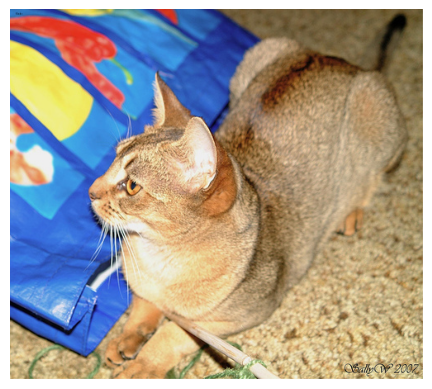

In [6]:
# 분할 마스크 모양 확인

import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

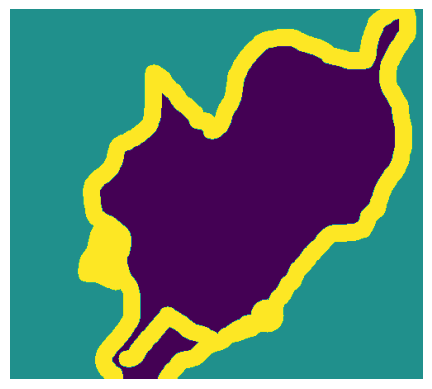

In [7]:
def display_target(target_array):
  normalized_array = (target_array.astype('uint8') - 1) * 127 # 이렇게 했을때 기대효과는...?
  plt.axis('off')
  plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode='grayscale'))
display_target(img)

In [8]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
  img = img_to_array(
      load_img(path, target_size=img_size, color_mode='grayscale'))
  img = img.astype('uint8') - 1
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

In [9]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [17]:
# 모델 정의
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
  x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

  x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
  x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

  x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

  x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size, 3)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_24 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_25 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_27 (Conv2D)          (None, 25, 25, 256)       2951

In [10]:
train_input_imgs.shape, train_targets.shape, val_input_imgs.shape, val_targets.shape

((6390, 200, 200, 3),
 (6390, 200, 200, 1),
 (1000, 200, 200, 3),
 (1000, 200, 200, 1))

In [18]:
# 모델 컴파일 및 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segment', save_best_only=1)
]
history = model.fit(train_input_imgs, train_targets,
                    epochs=3,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))


Epoch 1/3
100/100 [==============================] - 104s 789ms/step - loss: 0.9462 - val_loss: 0.8834
Epoch 2/3
100/100 [==============================] - 61s 605ms/step - loss: 0.8775 - val_loss: 0.8936
Epoch 3/3
100/100 [==============================] - 63s 635ms/step - loss: 0.8301 - val_loss: 0.8088


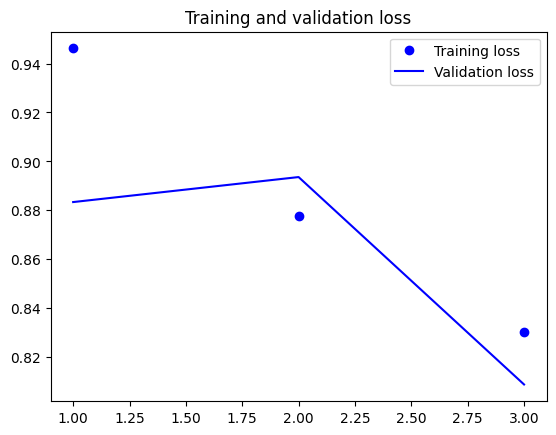

In [19]:
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

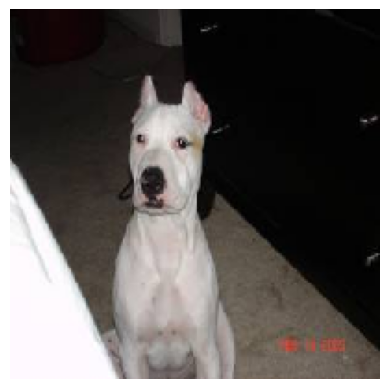

In [22]:
# 최상의 모델로 분할 마스크 예측
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model('oxford_segment')

i = 4
test_image = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_image))

1/1 [==============================] - 0s 31ms/step


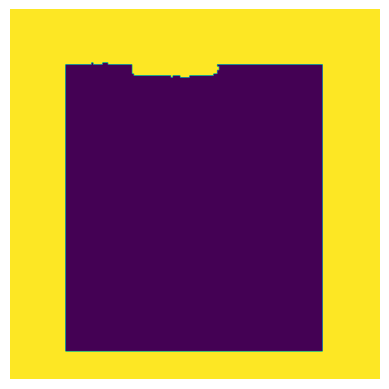

In [26]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis('off')
  plt.imshow(mask)

display_mask(mask)

## 9.3 최신 아키텍처 패턴

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

# 필터 수를 변경한 잔차블록
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding='same')(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

In [28]:
# 최대 풀링 층을 가진 잔차 블록

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [29]:
# 여러 블록으로 구성된 간단한 컨브넷 예 (이진 분류)

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 32, 32, 3)            0         ['input_10[0][0]']            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 32, 32, 32)           896       ['rescaling_5[0][0]']         
                                                                                                  
 conv2d_37 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_36[0][0]']           
                                                                                            

In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [31]:
# 컨브넷 아키텍처 원칙
'''
1. 모델은 반복되는 층 블록으로 조직되며, 블록은 일반적으로 여러 개의 학성곱 층과 최대 풀링층으로 구성된다.
2. 특성 맵의 공간 방향 크기를 줄이면 층의 필터 갯수는 늘려야 한다.
3. 깊고 좁은 아키텍처가 넓고 얕은 것보다 낫다.
4. 잔차 연결은 깊은 네트워크 훈련을 돕는다.
5. 합성곱 층 다음에 배치정규화 층을 더하면 도움이 된다.
6. Conv2D 층을 SeperableConv2D 층으로 바꾸면 도움이 된다.'''

# 위 원칙을 바탕으로 작성한 코드
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)

  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 180, 180, 3)          0         ['input_11[0][0]']            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 180, 180, 3)          0         ['sequential_1[0][0]']        
                                                                                                  
 conv2d_45 (Conv2D)          (None, 176, 176, 32)         2400      ['rescaling_6[0][0]']         
                                                                                            

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AIFFEL_Research_6th/DL with Python-케창딥/convnet_from_scratch_with_augmentation.k')

In [4]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

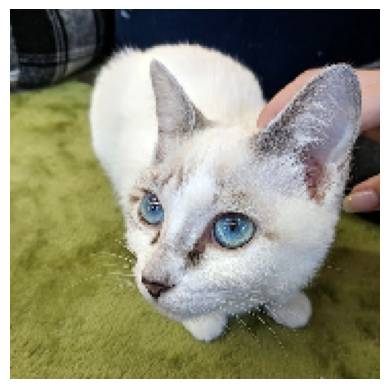

In [6]:
import numpy as np
import matplotlib.pyplot as plt

img_path = keras.utils.get_file(
    fname='cat.jpg',
    origin='https://img-datasets.s3.amazonaws.com/cat.jpg')

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(
      img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

img_tensor = get_img_array(img_path, target_size=(180,180))

plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [10]:
from keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [11]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 7s 7s/step


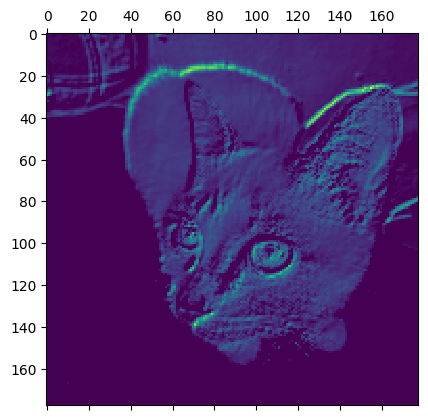

In [14]:
first_layer_activation = activations[0] # 첫번째 합성곱 층의 활성화 값
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

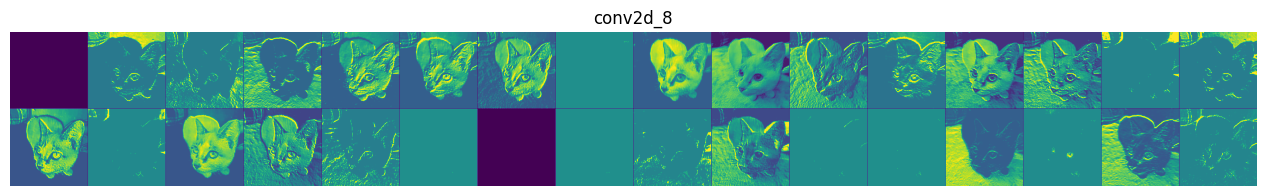

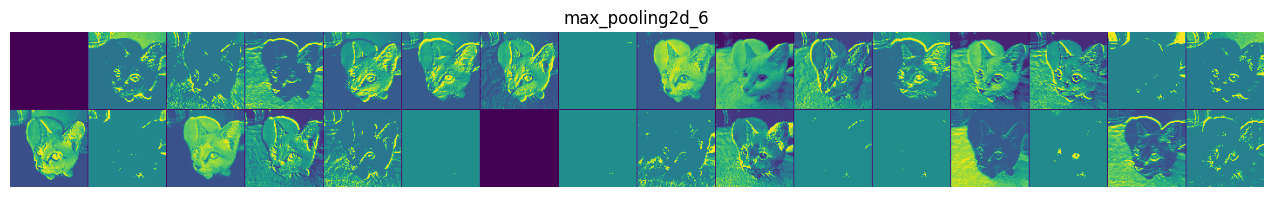

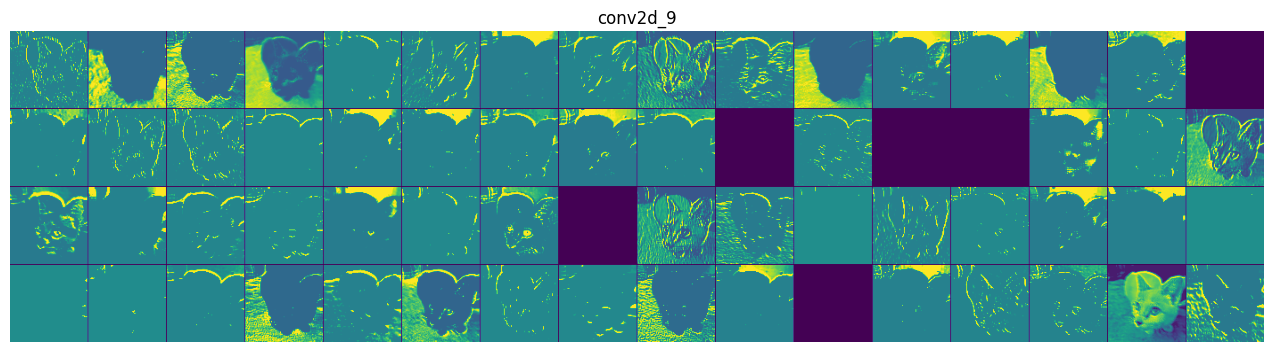

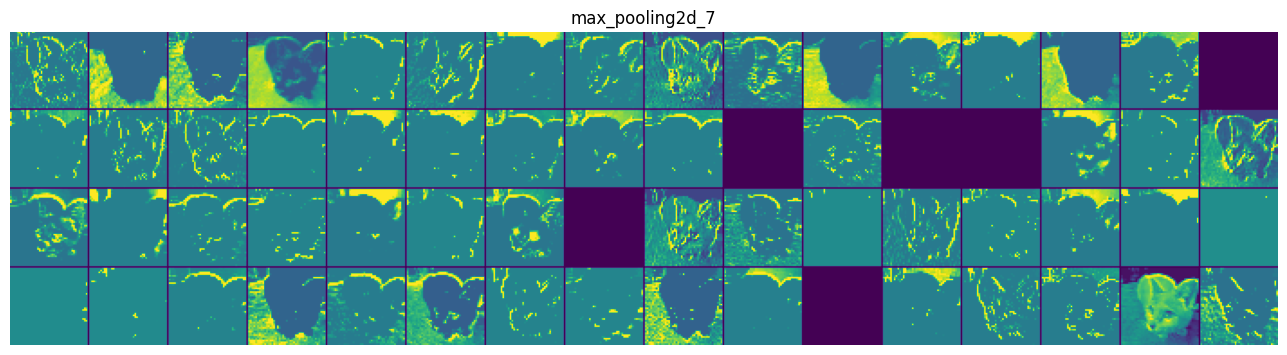

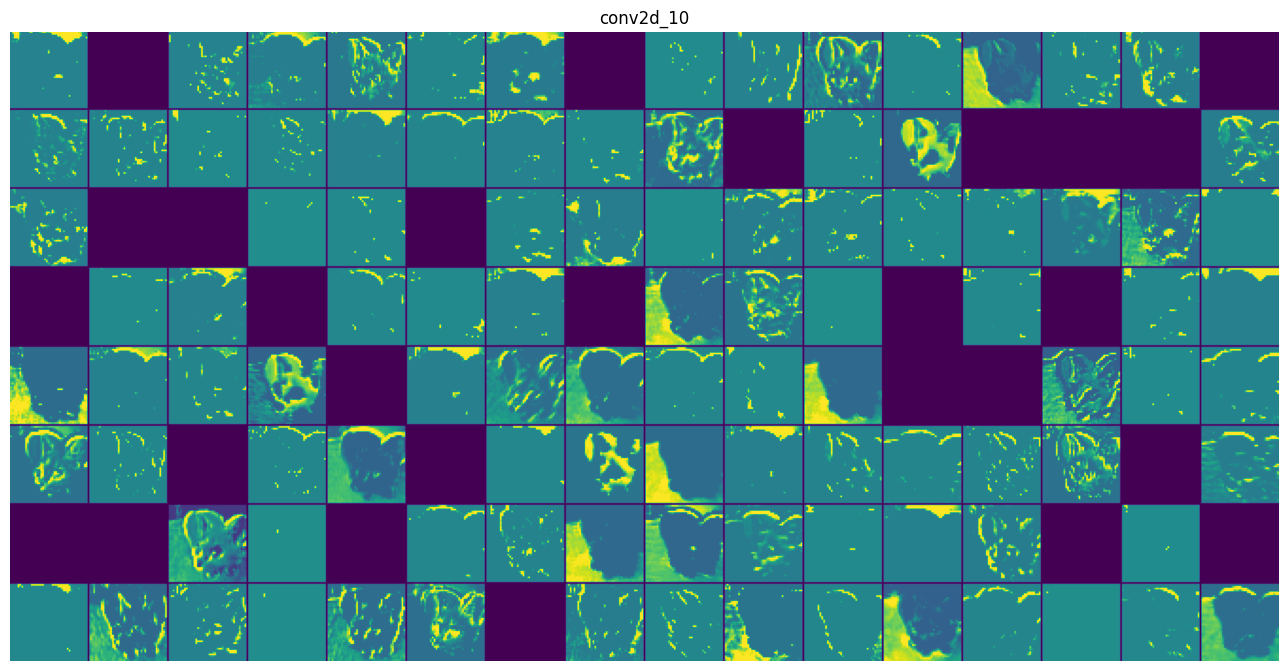

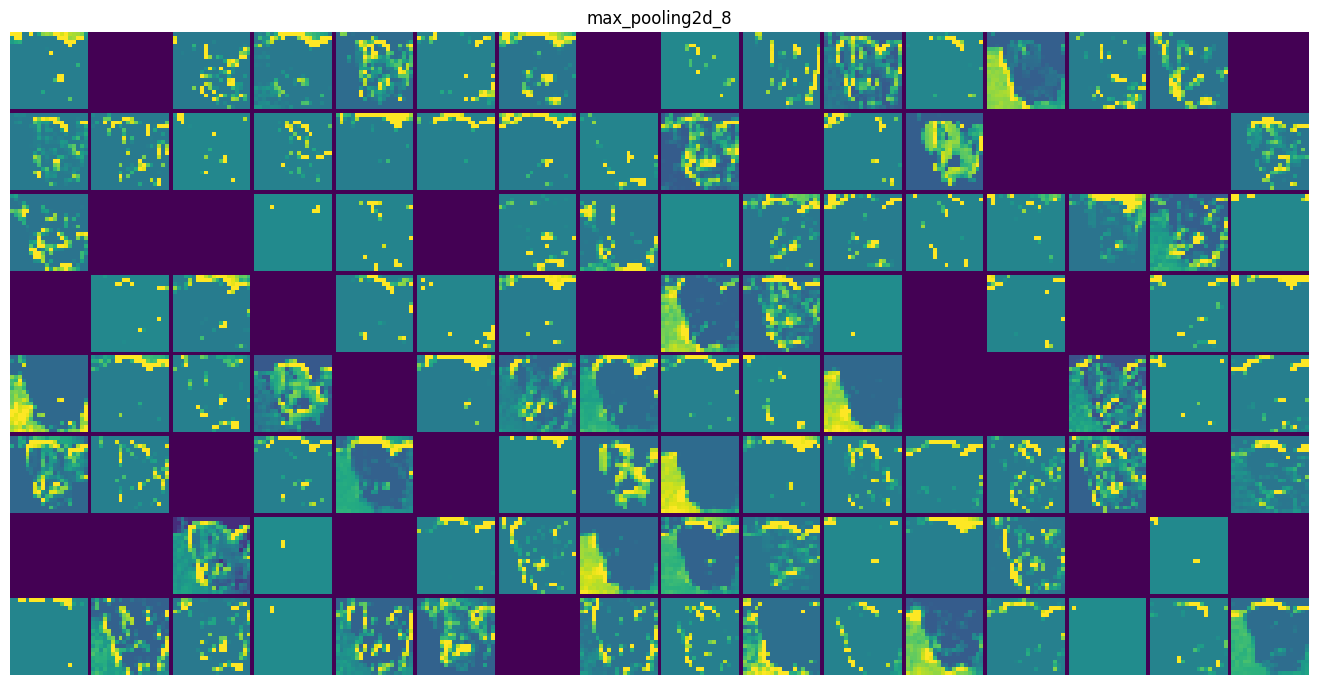

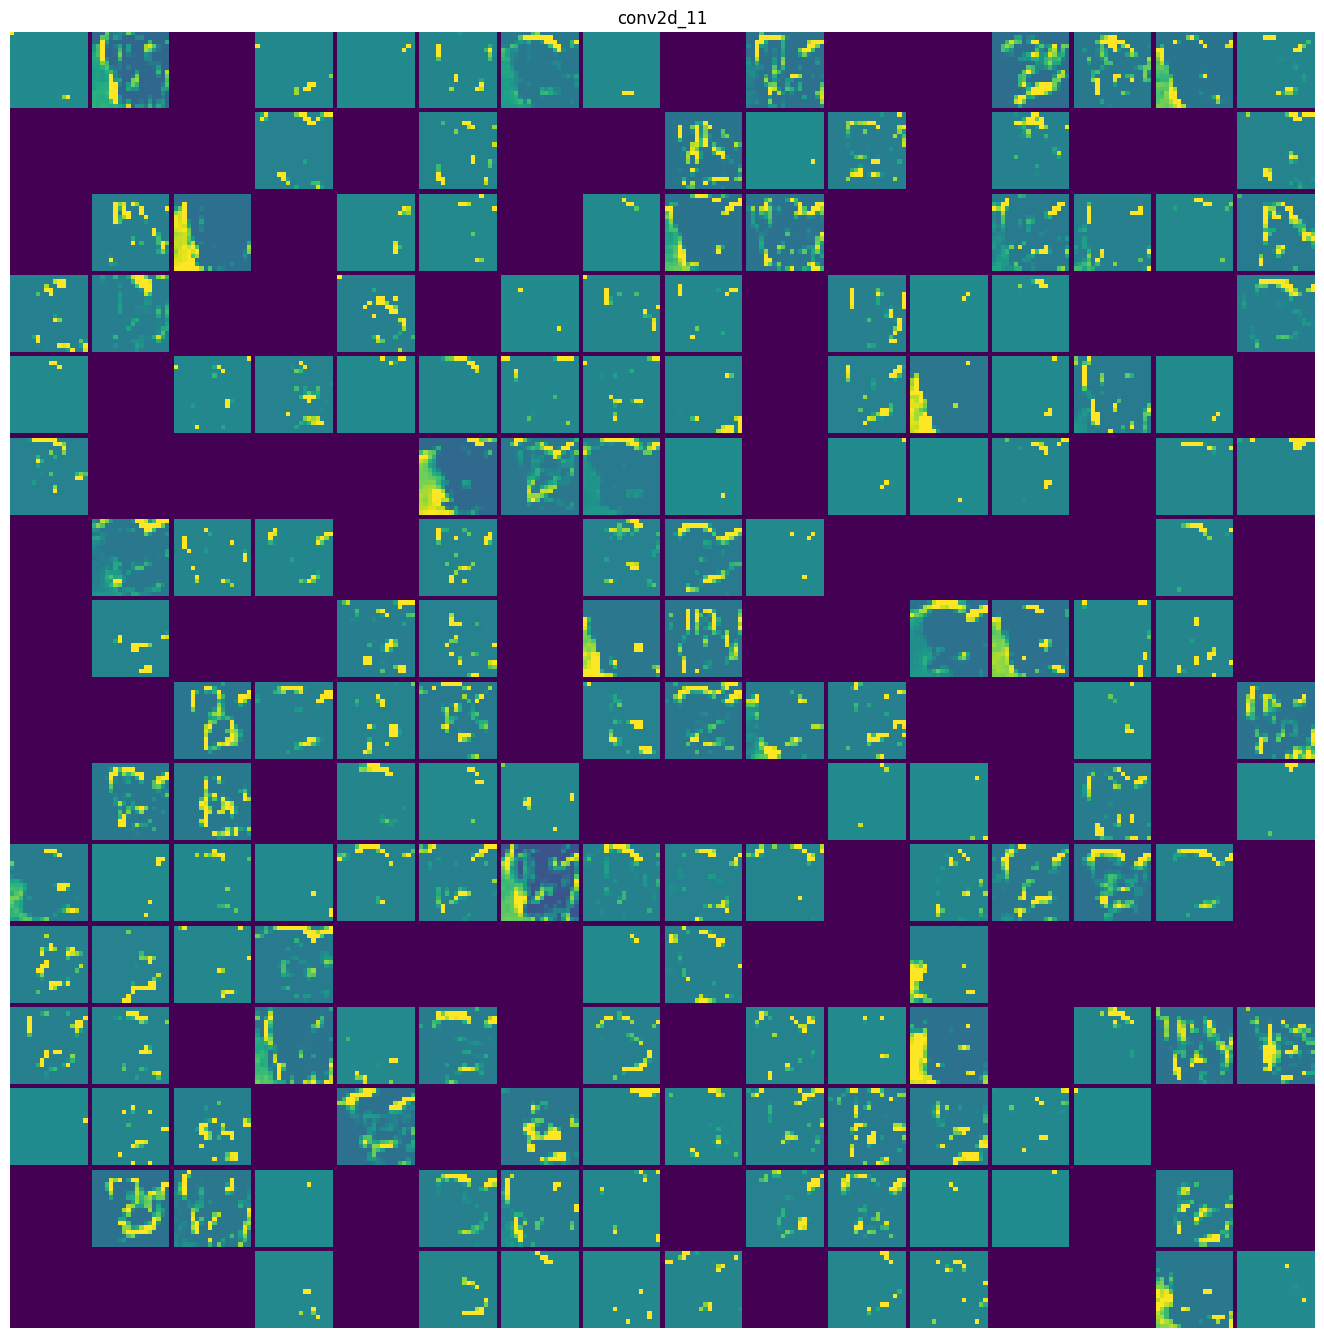

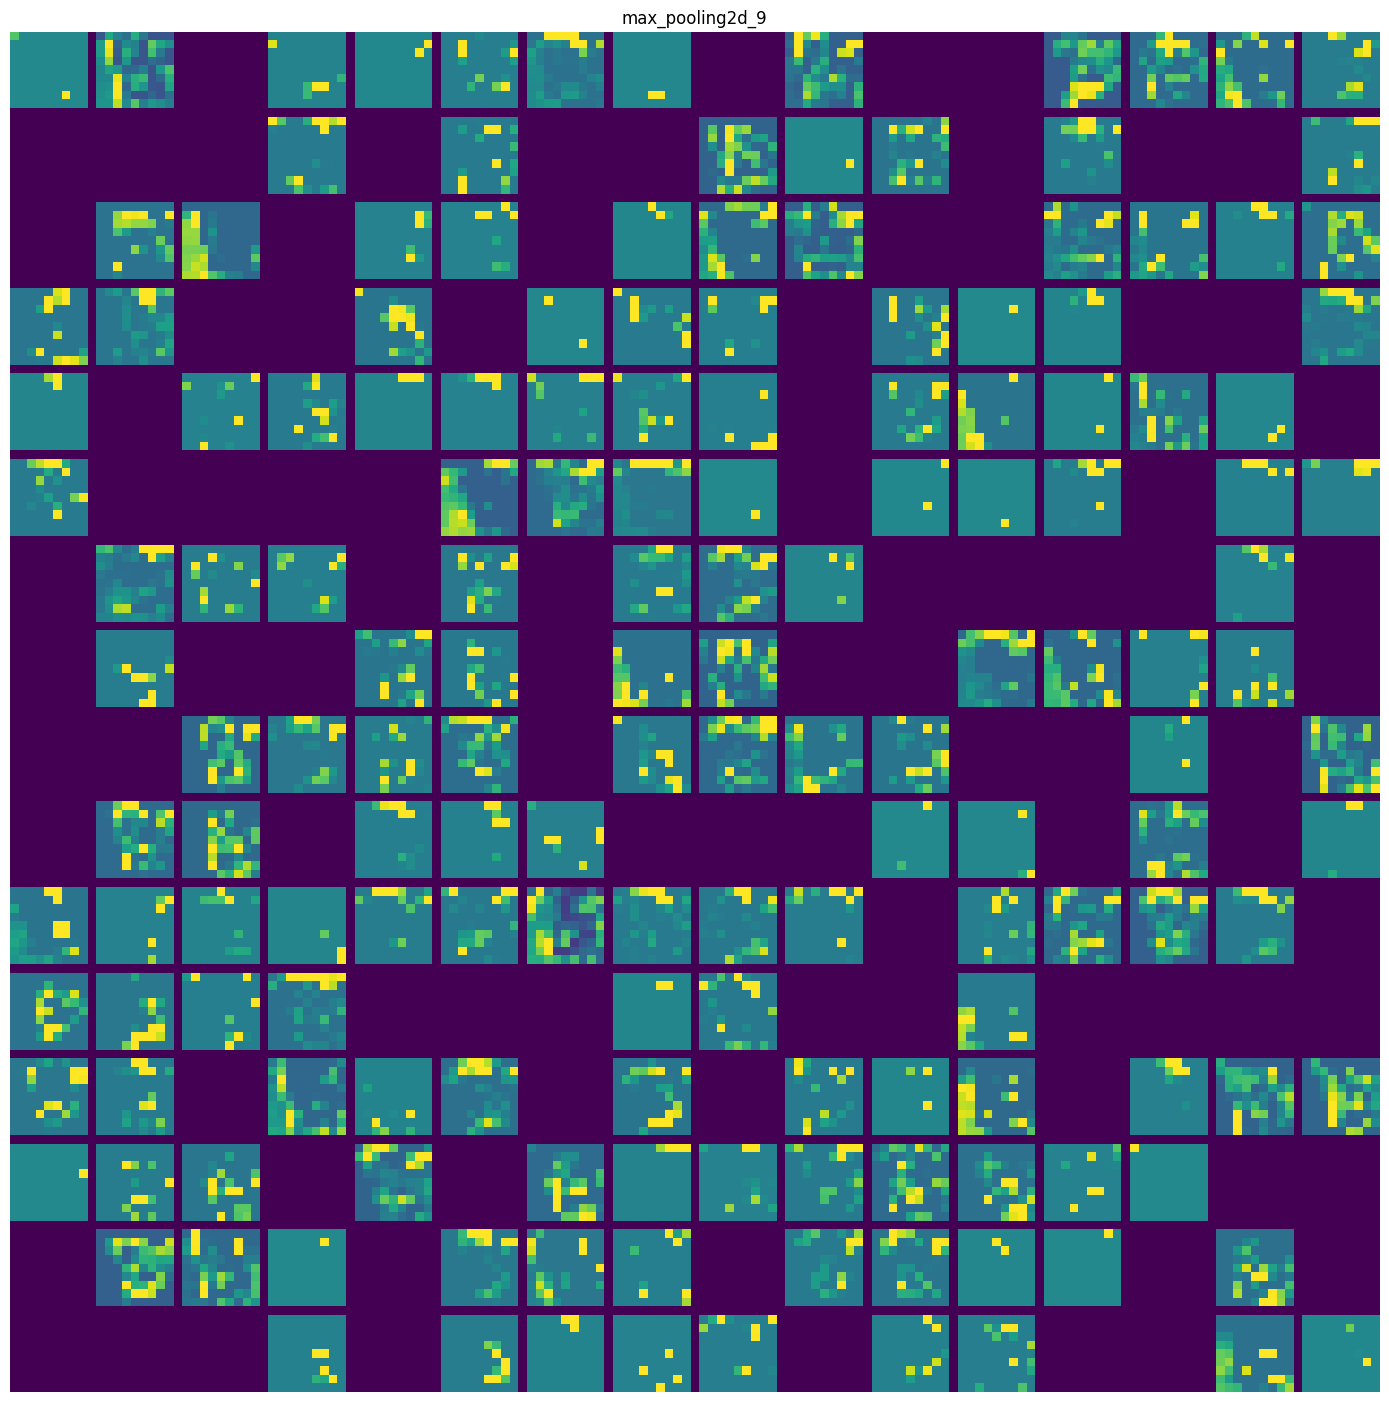

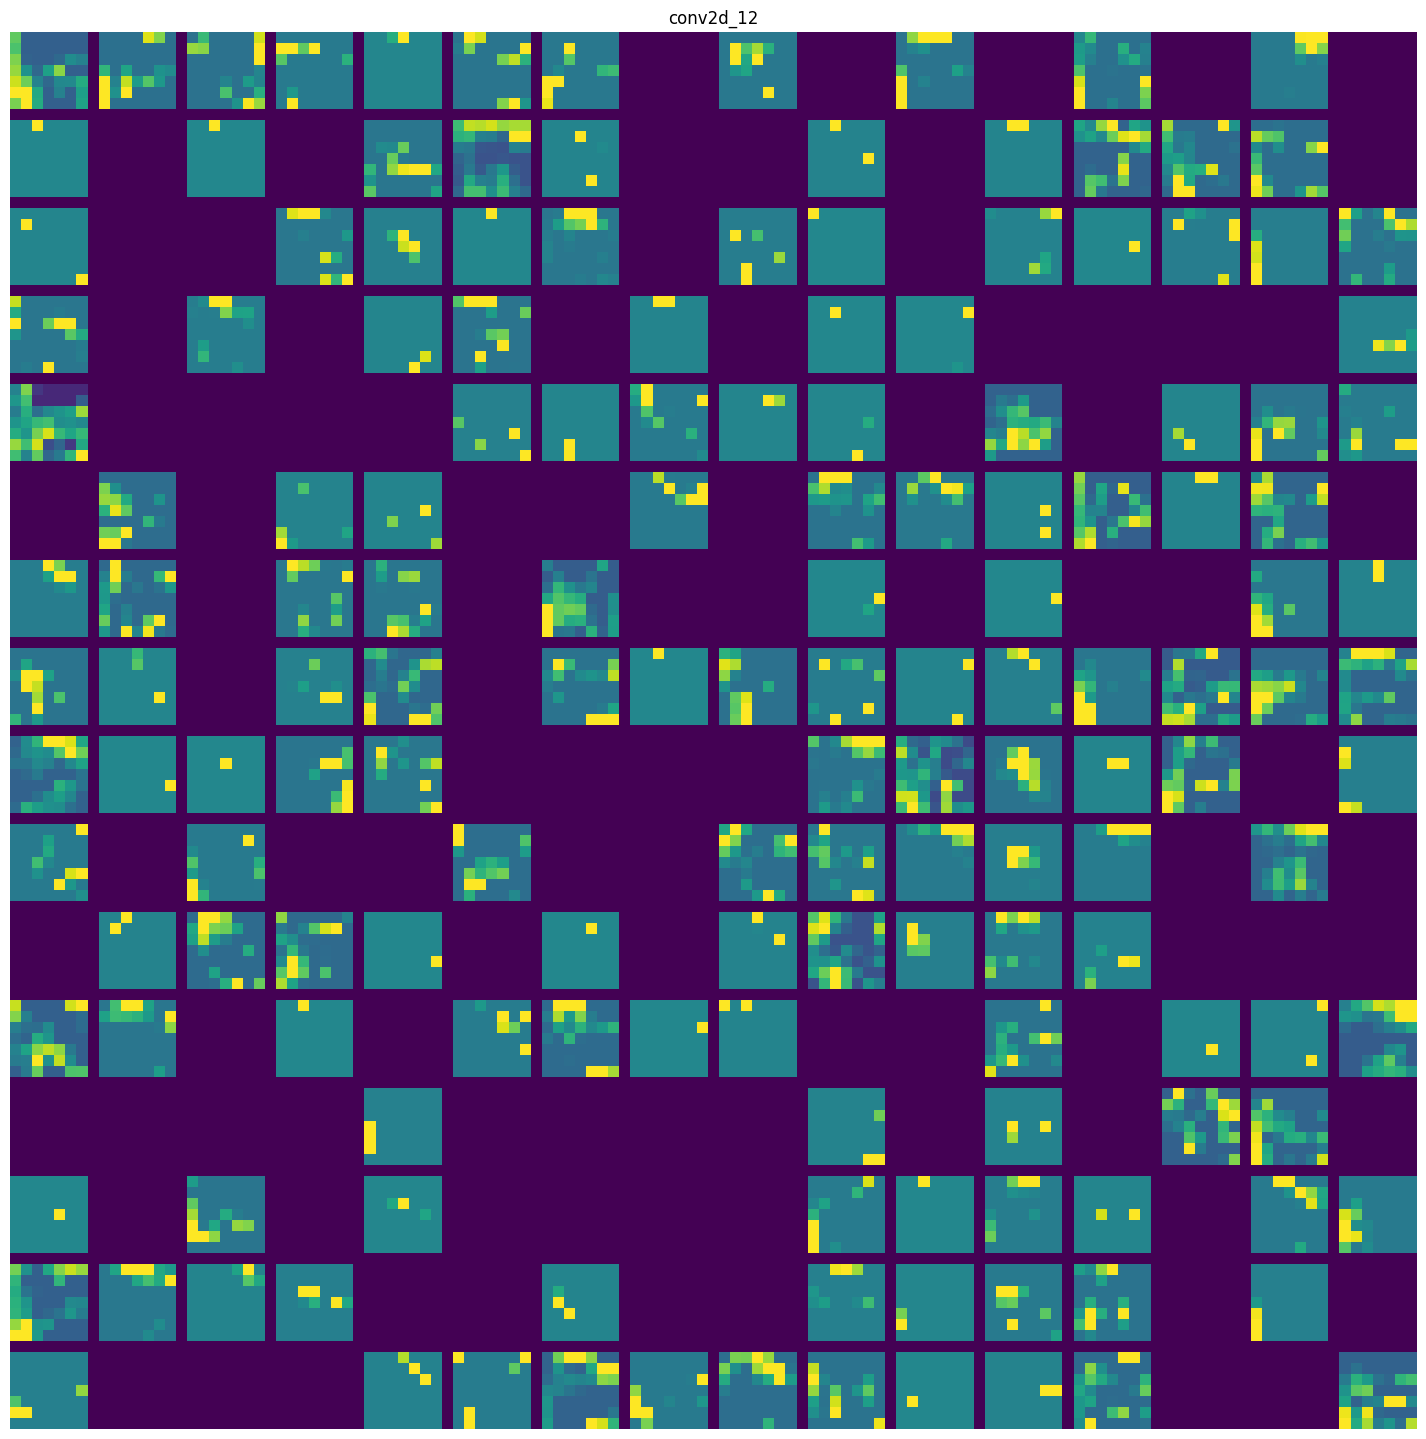

In [18]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0, :, :, channel_index].copy()
      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[
          col * (size + 1): (col + 1) * size + col,
          row * (size + 1): (row + 1) * size + row] = channel_image
  scale = 1. /size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(display_grid, aspect='auto', cmap='viridis')



In [19]:
# 필터 시각화
model = keras.applications.xception.Xception(
    weights = 'imagenet',
    include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


In [20]:
import tensorflow as tf

for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

layer_name = 'block3_sepconv1'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

def compute_loss(image, filter_index):
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image, filter_index)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return image

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


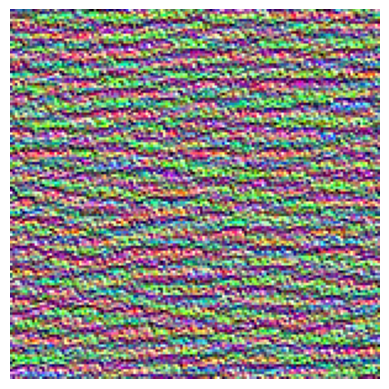

In [23]:
img_width = 200
img_height = 200
def generate_filter_pattern(filter_index):
  iterations = 30
  learning_rate = 10.
  image = tf.random.uniform(
      minval=0.4,
      maxval=0.6,
      shape=(1, img_width, img_height, 3))
  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate)
  return image[0].numpy()

def deprocess_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image += 128
  image = np.clip(image, 0, 255).astype('uint8')
  image = image[25:-25, 25:-25, :]
  return image

plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()